In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_list = drive.ListFile({'q': "'1O534TFNxUMcWBHi1hyuQgxx-1q3b6Bxy' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

ApiRequestError: ignored

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Petrol Pumps.csv to Petrol Pumps (1).csv


In [4]:
!pip install mpu

In [0]:
import mpu
import pandas as pd
import random
from __future__ import division
import warnings
from collections import Sequence
from itertools import repeat
import math
import string
import sys
import matplotlib.pyplot as plt
import itertools
from math import radians, cos, sin, asin, sqrt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
import matplotlib.cm as cmx
import matplotlib.colors as colors
from scipy.cluster.vq import kmeans2, whiten

In [0]:
latlong = pd.read_csv('Petrol Pumps.csv', sep = ";", header = None)
latlong=pd.DataFrame(data=latlong)
latitude = latlong.iloc[:, 1:2]
longitude = latlong.iloc[:,2:3]
lat = list()
long = list()
de = list()
for i in range(0,131):
  if latitude.iloc[i,0] < 28.82 and latitude.iloc[i,0] > 27.5 and longitude.iloc[i,0] > 77:
    lat.append(latitude.iloc[i,0])
    long.append(longitude.iloc[i,0])

latlong_2 = pd.DataFrame({0: lat,1: long})

In [7]:
coordinates = latlong_2.as_matrix(columns=[0,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
def getClusterPoints(V, labels):
    clusters = {}
    for l in range(0, max(labels)+1):
        data_points = []
        indices = [i for i, x in enumerate(labels) if x == l]
        for idx in indices:
            data_points.append(V[idx])
        clusters[l] = data_points
    return clusters

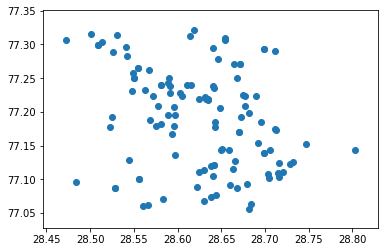

In [9]:
plt.scatter(coordinates[:,0],coordinates[:,1])

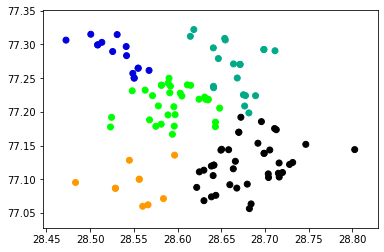

In [10]:
from sklearn.cluster import KMeans
n = 5
cluster = KMeans(n).fit(coordinates)
plt.scatter(coordinates[:,0],coordinates[:,1], c=[plt.cm.nipy_spectral(float(i) /n) for i in cluster.labels_])
plt.show()

In [0]:
lat.insert(0,28.625)
long.insert(0,77.175)

In [0]:
cluster_label_list = list()
for i in range(0,len(cluster.labels_)):
  cluster_label_list.append(cluster.labels_[i])
cluster_list = list()
for i in range(0,n):
  cluster_list.append([j for j,x in enumerate(cluster_label_list) if x==i])

In [0]:
# FUNCTION TO GENERATE A POPULATION OF ROUTES HAVING DISTANCE LESS THAN MAX_DIST KMS
def pop_generation(l1,lat,long,max_dist):
  x = 0
  total_dist = 0
  points = list()
  for i in range(0,len(l1)):
    points.append(l1[i])
  route = list()
  while(1):
    idx = random.randint(0,len(points)-1)
    y=points[idx]
    lat1 = lat[x]
    lat2 = lat[y]
    lon1 = long[x]
    lon2 = long[y]
    distance = mpu.haversine_distance((lat1, lon1), (lat2, lon2)) 
    distance0 = mpu.haversine_distance((lat[0], long[0]), (lat2, lon2))  
    total_dist = total_dist + distance
    if total_dist + distance0 < max_dist:      
      route.append(y)
      x = y  
      points.remove(x)
    else:
      total_dist = total_dist + (mpu.haversine_distance((lat[0], long[0]), (lat1, lon1))) - distance 
      break
    if len(points)==0:
      break
  return route

In [0]:
# FUNCTION TO CALCULATE DISTANCE ALONG A ROUTE
def distance_check(routes,latitude,longitude):
  total_distance = 0
  d0x = mpu.haversine_distance((latitude[0], longitude[0]), (latitude[routes[0]], longitude[routes[0]]))
  dx0 = mpu.haversine_distance((latitude[routes[len(routes)-1]], longitude[routes[len(routes)-1]]), (latitude[0], longitude[0]))
  for i in range (0,len(routes)-1):
    lat1 = latitude[routes[i]]
    lat2 = latitude[routes[i+1]]
    lon1 = longitude[routes[i]]
    lon2 = longitude[routes[i+1]]
    distance = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
    total_distance = total_distance + distance 
  return total_distance + d0x + dx0

In [0]:
def distance_check_2(routes,latitude,longitude):
  total_distance = 0
  for i in range (0,len(routes)-1):
    lat1 = latitude[routes[i]]
    lat2 = latitude[routes[i+1]]
    lon1 = longitude[routes[i]]
    lon2 = longitude[routes[i+1]]
    distance = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
    total_distance = total_distance + distance 
  return total_distance

In [0]:
# FUNCTION TO CALCULATE THE PROFIT GENERATED WHILE TRAVELLING A ROUTE
def fitness(routes,profits,lat,long):
  total_profit = 0
  for i in range (0,len(routes)):
    total_profit = total_profit + profits[routes[i]]
  routes.append(0)
  routes.insert(0,0)
  d = distance_check_2(routes,lat,long)
  routes.remove(0)
  routes.remove(0)
  return total_profit - (2*d)

In [0]:
# FUNCTION FOR TOURNAMENT SELECTION - SELECTS 5 RANDOM ROUTES AND PASSES THE ONE WITH THE HIGHEST PROFIT
def selection(populations,route_profit):
  t_size = 10
  new_pop = list()
  for i in range(0, len(populations)):
    profit = list()
    tournament_pop = list()
    for i in range(0, t_size):
      best_idx=0
      idx = random.randint(0,len(populations)-1)
      profit.append(route_profit[idx])
      tournament_pop.append(populations[idx])
    best_idx = profit.index(max(profit))
    new_pop.append(tournament_pop[best_idx])
    profit.clear()
    tournament_pop.clear()
  return new_pop
    

In [0]:
# FUNCTION TO PERFORM CROSSOVER OVER THE ROUTES
def _repeated(element, collection):
  c = 0
  for e in collection:
      if e == element:
          c += 1
  return c > 1
  
def _swap(data_a, data_b, cross_points):
  c1, c2 = cross_points
  new_a = data_a[:c1] + data_b[c1:c2] + data_a[c2:]
  new_b = data_b[:c1] + data_a[c1:c2] + data_b[c2:]
  return new_a, new_b

def _map(swapped, cross_points):
  n = len(swapped[0])
  c1, c2 = cross_points
  s1, s2 = swapped
  map_ = s1[c1:c2], s2[c1:c2]
  for i_chromosome in range(n):
      if not c1 < i_chromosome < c2:
          for i_son in range(2):
              while _repeated(swapped[i_son][i_chromosome], swapped[i_son]):
                  map_index = map_[i_son].index(swapped[i_son][i_chromosome])
                  swapped[i_son][i_chromosome] = map_[1-i_son][map_index]
  return s1, s2
  
def pmx(parent_a, parent_b):
    n = len(parent_a)
    cross_points = sorted([random.randint(0, n) for _ in range(2)])
    swapped = _swap(parent_a, parent_b, cross_points)
    s1,s2 = _map(swapped, cross_points)
    return s1,s2
  
def crossover(population, profits,lat,long,l1,l2,l3,l4):
  for i in range(0,int(len(population))):
    n1 = random.randint(0,len(population)-1)
    n2 = random.randint(0,len(population)-1)
    while n1==n2:
      n2 = random.randint(0,len(population)-1)
    parent1 = population[n1]
    parent2 = population[n2]
    if len(parent1) == len(parent2):
      child1,child2 = pmx(parent1, parent2)
      l1.append(parent1)
      l2.append(parent2)
      l3.append(child1)
      l4.append(child2)
  return l1,l2,l3,l4

In [0]:
# ASSIGN PROFITS TO THE NODES AND PUT THEM IN A LIST
profits = list()
profits.append(0)
for i in range (0,len(lat)-1):
  p = random.randint(1,10)
  p = p*10
  profits.append(p)

[[107, 111, 34, 20, 53, 16, 89, 62, 64, 6, 93, 47, 30, 72, 84, 88, 8, 49, 9, 80], [63, 45, 20, 9, 64, 35, 49, 111, 89, 8, 88, 16, 30, 80, 108, 84, 93, 72, 13, 0], [30, 103, 115, 35, 20, 6, 62, 58, 111, 89, 49, 53, 47, 80, 88, 25, 93, 9, 84, 72], [30, 103, 115, 9, 20, 6, 62, 58, 111, 89, 49, 53, 47, 80, 88, 25, 93, 35, 84, 72], [30, 103, 115, 35, 20, 6, 62, 58, 111, 89, 49, 53, 47, 80, 88, 25, 93, 9, 84, 72], [115, 72, 62, 9, 112, 64, 87, 58, 111, 89, 49, 53, 47, 80, 88, 25, 93, 13, 30, 15], [63, 45, 20, 9, 64, 35, 49, 111, 89, 8, 88, 16, 30, 80, 108, 84, 93, 72, 13, 0], [63, 45, 20, 9, 64, 35, 49, 111, 89, 8, 88, 16, 30, 80, 108, 84, 93, 72, 13, 0], [30, 103, 115, 35, 20, 6, 62, 58, 111, 89, 49, 53, 47, 80, 88, 25, 93, 9, 84, 72], [63, 45, 20, 9, 64, 35, 49, 111, 89, 8, 88, 16, 30, 80, 108, 84, 93, 72, 13, 0], [64, 9, 58, 34, 73, 103, 15, 108, 84, 89, 63, 80, 45, 52, 13, 49, 115, 62, 72, 87, 111], [48, 58, 25, 88, 9, 103, 93, 30, 84, 108, 111, 16, 112, 47, 72, 28, 87, 64, 115, 35, 0], 

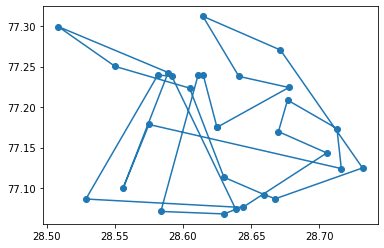

[[81, 44, 114, 68, 70, 32, 51, 43, 66, 91, 7, 113, 59, 24, 116], [59, 91, 70, 24, 51, 7, 32, 68, 44, 114, 43, 66, 81, 113, 116], [114, 44, 68, 51, 59, 66, 32, 70, 43, 81, 113, 116, 24, 91, 7], [7, 81, 70, 51, 32, 116, 59, 66, 68, 113, 44, 114, 43, 24, 91], [7, 116, 68, 24, 114, 44, 51, 70, 43, 59, 32, 66, 81, 113, 91], [114, 66, 7, 113, 70, 43, 68, 24, 32, 59, 51, 81, 116, 44, 91], [116, 24, 68, 32, 7, 70, 59, 113, 81, 43, 114, 44, 91, 66, 51], [59, 113, 114, 44, 81, 7, 51, 68, 66, 24, 70, 32, 43, 116, 91], [66, 81, 51, 43, 68, 59, 70, 7, 24, 32, 44, 114, 116, 113, 91], [59, 91, 66, 24, 81, 7, 32, 114, 44, 43, 51, 116, 68, 70, 113], [113, 68, 66, 44, 114, 51, 24, 59, 32, 70, 81, 116, 91, 43, 7], [68, 113, 51, 59, 116, 91, 32, 66, 70, 81, 43, 7, 24, 44, 114], [70, 81, 59, 7, 113, 114, 44, 51, 43, 32, 91, 68, 24, 66, 116], [43, 81, 91, 116, 70, 66, 24, 44, 114, 68, 7, 32, 51, 59, 113], [51, 116, 114, 66, 32, 70, 81, 44, 24, 68, 43, 91, 59, 113, 7], [59, 114, 44, 68, 43, 116, 24, 91, 81, 

KeyboardInterrupt: ignored

In [28]:
for index in range(len(cluster_list)):
  # ASSIGN THE ROUTES LESS THAN MAX_DIST KMS IN A LIST
  populations = list()
  route_profit = list()
  max_dist = 300
  l1 = cluster_list[index]
  for i in range(0,2000):
    l2=l1
    populations.append(pop_generation(l2,lat,long,max_dist))
  for i in range(0,len(populations)):
    route_profit.append(fitness(populations[i],profits,lat,long))

  new_population = populations

  for q in range(0,20):
    #PERFORM TOURNAMENT SELECTION OVER ALL THE POPULATIONS
    t_size = 10
    new_population = selection(new_population, route_profit)
    # SORT THE ROUTES IN INCREASING ORDER OF LENGTHS
    new_population.sort(key=len)
    count = 1
    length_routes = list()
    for i in range(0,len(new_population)-1):
      if len(new_population[i]) == len(new_population[i+1]):
        count = count + 1
      else:
        length_routes.append(count)
        count = 1
      if i == len(new_population)-2:
        length_routes.append(count) 
    # PERFORM CROSSOVER OVER THE NEW POPULATION GENERATED AFTER TOURNAMENT SELECTION
    count=0
    l1 = list()
    l2 = list()
    l3 = list()
    l4 = list()
    for i in range(0,len(length_routes)):
      c_list = list()
      if length_routes[i] == 1:
        i = i+1
      else:
        for j in range(0,length_routes[i]):    
          c_list.append(new_population[count])
          count=count+1
        crossover(c_list, profits,lat,long,l1,l2,l3,l4)
    # SEND THE BEST 2 FROM PARENT_1, PARENT_2, CHILD_1, CHILD_2 FORWARD
    crossed_over_list = list()
    crossed_over_profit = list()
    for j in range(0,len(l1)):
      x = list()
      d1 = distance_check(l1[j],lat,long)
      d2 = distance_check(l2[j],lat,long)
      d3 = distance_check(l3[j],lat,long)
      d4 = distance_check(l4[j],lat,long)
      if d1 <= max_dist:
        x.append(l1[j])
      if d2 <= max_dist:
        x.append(l2[j])
      if d3 <= max_dist:
        x.append(l3[j])
      if d4 <= max_dist:
        x.append(l4[j])    
      temp_list = list()
      for i in range(0, len(x)):
        temp_list.append(fitness(x[i],profits,lat,long))   
      idx = temp_list.index(max(temp_list)) 
      best1 = x[idx]
      crossed_over_list.append(best1)
    print(crossed_over_list)
    for i in range(0,len(crossed_over_list)):
      crossed_over_profit.append(fitness(crossed_over_list[i],profits,lat,long))
    print(max(crossed_over_profit))
    new_population = crossed_over_list
    route_profit = crossed_over_profit

  plot = list()
  idx = crossed_over_profit.index(max(crossed_over_profit))
  for i in range(0,len(crossed_over_list[idx])):
    plot.append(crossed_over_list[idx][i])
  print(plot)

  d = distance_check(plot, lat, long)
  print(d,plot)

  max(crossed_over_profit)

  plot.insert(0,0)
  plot.append(0)
  print(plot)
  x = list()
  y = list()
  for i in range(0,len(plot)): 
    x.append(lat[plot[i]])
    y.append(long[plot[i]])

  plt.plot(x, y, marker = 'o')
  plt.show()